N-BEATS

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
theta_dim = 8
num_blocks = 3  
epochs = 70
lr = 1e-3
batch_size = 16

# N-BEATS Block
class FullyConnectedBlock(nn.Module):
    def __init__(self, input_dim, theta_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.theta_layer = nn.Linear(512, theta_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.theta_layer(x)

# N-BEATS Model
class NBEATS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=15):
        super().__init__()
        self.blocks = nn.ModuleList([
            FullyConnectedBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])
        self.backcast_linear = nn.Linear(theta_dim, input_dim)
        self.forecast_linear = nn.Linear(theta_dim, 1)

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            theta = block(x)
            backcast = self.backcast_linear(theta)
            forecast += self.forecast_linear(theta)
            x = x - backcast
        return forecast

# Assuming X_train, y_train, X_test, y_test are defined elsewhere
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# Initialize model, optimizer, loss
model = NBEATS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

N-HITS

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# ---- Hyperparameters ----
theta_dim = 6
num_blocks = 3
epochs = 70
lr = 1e-3
batch_size = 16

# ==== Fully connected projection for each N-HiTS block ====
class NHITSBlock(nn.Module):
    def __init__(self, input_dim, theta_dim):
        super().__init__()
        self.backcast_fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, theta_dim),
            nn.ReLU(),
            nn.Linear(theta_dim, input_dim)
        )
        self.forecast_fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, theta_dim),
            nn.ReLU(),
            nn.Linear(theta_dim, 1)
        )

    def forward(self, x):
        backcast = self.backcast_fc(x)
        forecast = self.forecast_fc(x)
        return backcast, forecast

# ==== NHITS model ====
class NHITS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            NHITSBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])

    def forward(self, x):
        forecast_total = 0
        for block in self.blocks:
            backcast, forecast = block(x)
            x = x - backcast  # residual learning
            forecast_total += forecast
        return forecast_total

# ==== Prepare Tensors ====
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# ==== DataLoaders ====
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# ==== Initialize model and training components ====
model = NHITS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

Quantum B-BEATS

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
n_qubits = 8
n_layers = 3  # Reduced for speed
theta_dim = 8
num_blocks = 3  # Reduced for speed
epochs = 70
lr = 1e-3
batch_size = 16

# Device setup using fast simulator
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the quantum circuit
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    for layer_weights in weights:
        for i in range(n_qubits):
            qml.RY(layer_weights[i], wires=i)
        for i in range(0, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Setup QNode
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="adjoint")
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Define a quantum block with batched input
class QuantumBlock(nn.Module):
    def __init__(self, in_features, theta_dim):
        super().__init__()
        self.fc = nn.Linear(in_features, n_qubits)
        self.norm = nn.LayerNorm(n_qubits)
        self.q_layer = qlayer
        self.post_fc = nn.Linear(n_qubits, theta_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.norm(x)
        x_q = self.q_layer(x)  # Batched input to qlayer
        return self.post_fc(x_q)

# N-BEATS architecture with quantum blocks
class QuantumNBEATS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            QuantumBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])
        self.backcast_linear = nn.Linear(theta_dim, input_dim)
        self.forecast_linear = nn.Linear(theta_dim, 1)

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            theta = block(x)
            backcast = self.backcast_linear(theta)
            forecast += self.forecast_linear(theta)
            x = x - backcast
        return forecast
    
# Prepare data
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# Initialize model, optimizer, loss
model = QuantumNBEATS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

Quantum N-HITS

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- Device Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"💻 Using device: {device}")

# ---- Hyperparameters ----
n_qubits = 4
n_layers = 2
theta_dim = 4
num_blocks = 2
epochs = 70
lr = 1e-3
batch_size = 8
forecast_dim = 1

# ---- Quantum device ----
dev = qml.device("lightning.qubit", wires=n_qubits)

# ---- Quantum circuit ----
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    for layer_weights in weights:
        for i in range(n_qubits):
            qml.RY(layer_weights[i], wires=i)
        for i in range(0, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ---- QNode and TorchLayer ----
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="adjoint")
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# ==== Quantum N-HiTS Block ====
class QuantumNHITSBlock(nn.Module):
    def __init__(self, input_dim, theta_dim, forecast_dim):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, n_qubits)
        self.norm = nn.LayerNorm(n_qubits)
        self.q_layer = qlayer
        self.theta_fc = nn.Linear(n_qubits, theta_dim)
        self.backcast_fc = nn.Linear(theta_dim, input_dim)
        self.forecast_fc = nn.Linear(theta_dim, forecast_dim)

    def forward(self, x):
        x = self.norm(self.fc_in(x))
        x_q = self.q_layer(x)
        theta = self.theta_fc(x_q)
        backcast = self.backcast_fc(theta)
        forecast = self.forecast_fc(theta)
        return backcast, forecast

# ==== Quantum N-HiTS Model ====
class QuantumNHITS(nn.Module):
    def __init__(self, input_dim, theta_dim, forecast_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            QuantumNHITSBlock(input_dim, theta_dim, forecast_dim)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        forecast_total = 0
        for block in self.blocks:
            backcast, forecast = block(x)
            forecast_total += forecast
            x = x - backcast
        return forecast_total

# ---- Convert to tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# ---- DataLoaders ----
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# ---- Initialize model and training components ----
model = QuantumNHITS(input_dim=X_train.shape[1], theta_dim=theta_dim, forecast_dim=forecast_dim, num_blocks=num_blocks).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
20:41:52 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing


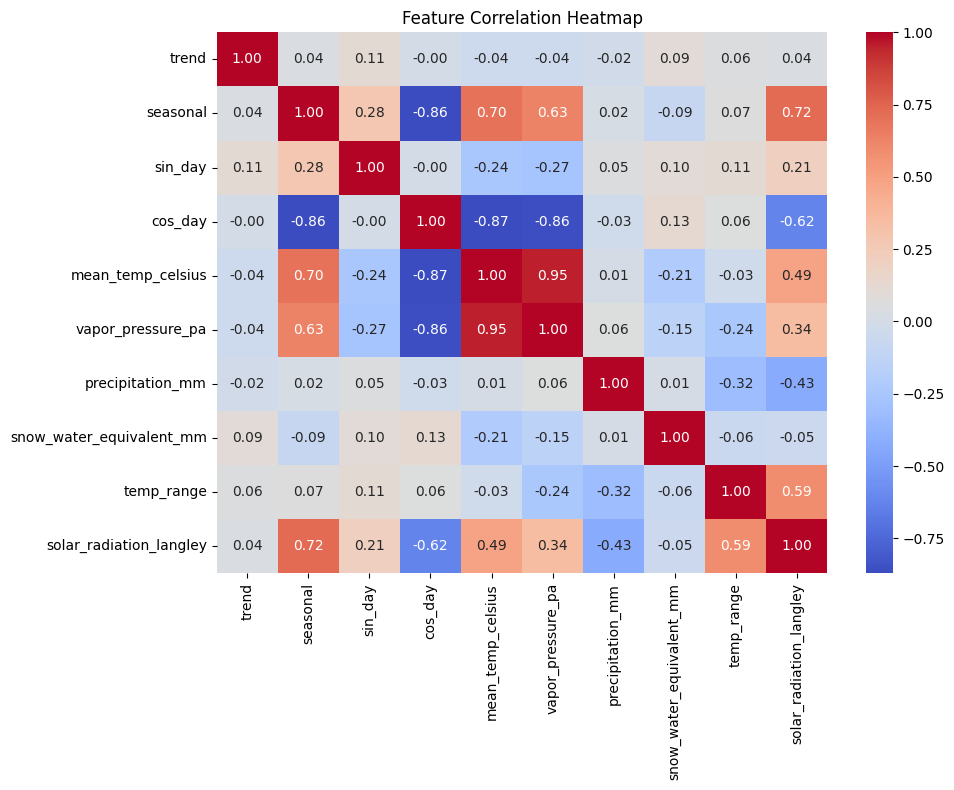

In [1]:
import pandas as pd
from prophet import Prophet

train_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\train_data.csv")
test_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\test_data.csv")

prophet_train = train_df[["date", "solar_radiation_langley"]].copy()
prophet_train.columns = ["ds", "y"]

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

# For training data
train_future = prophet_train[["ds"]]
train_forecast = model.predict(train_future)

train_df["trend"] = train_forecast["trend"].values
train_df["seasonal"] = train_forecast["yearly"].values + train_forecast["daily"].values
train_df["residual"] = train_df["solar_radiation_langley"] - train_df["trend"] - train_df["seasonal"]

# For testing data
prophet_test = test_df[["date"]].copy()
prophet_test.columns = ["ds"]
test_forecast = model.predict(prophet_test)

test_df["trend"] = test_forecast["trend"].values
test_df["seasonal"] = test_forecast["yearly"].values + test_forecast["daily"].values
test_df["residual"] = test_df["solar_radiation_langley"] - test_df["trend"] - test_df["seasonal"]

df = pd.concat([train_df, test_df], ignore_index=True)

input_features = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range", 'solar_radiation_langley'
]

df = df[input_features]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = pd.DataFrame(df, columns=input_features).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("feature_correlation_heatmap2.png")
plt.show()

C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_9448\1077582557.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'], errors='coerce')
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:55 - cmdstanpy - INFO - Chain [1] done processing


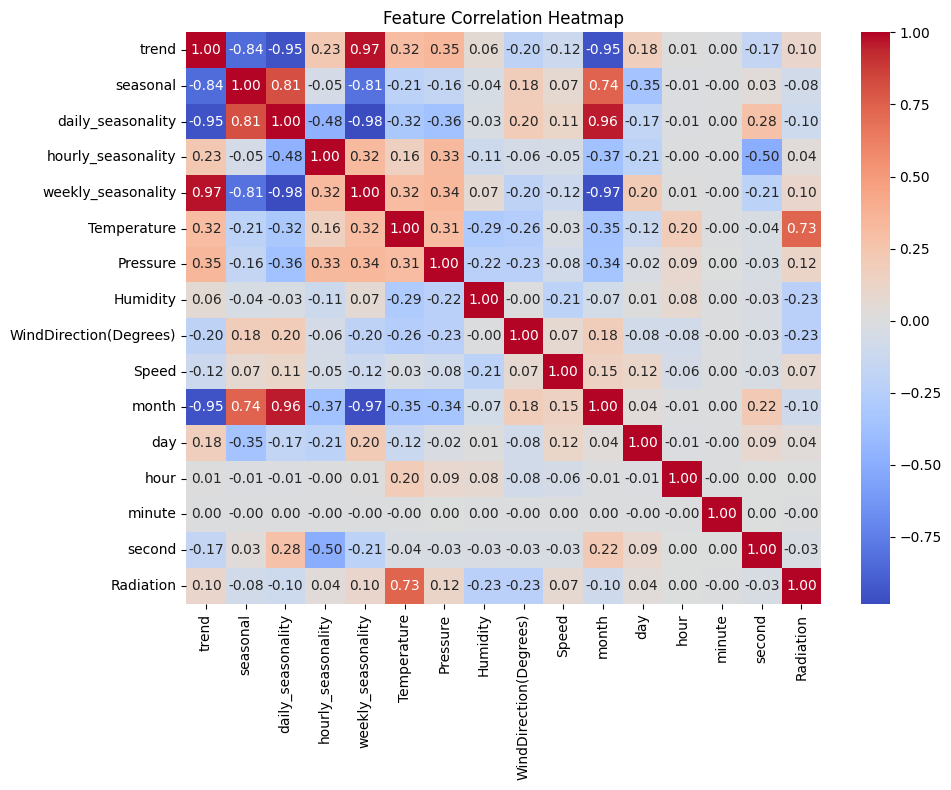

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# -------------------------------
# 1. Load and Preprocess Data
# -------------------------------

# Load dataset
df = pd.read_csv(r'D:\Projects\quantum forecasting\dataset\kaggle data\Solar_Prediction.csv')

# Combine 'Data' and 'Time' into a single datetime column
df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'], errors='coerce')

# Drop unnecessary columns
df.drop(['UNIXTime', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# -----------------------------------
# 2. Prepare data for Prophet model
# -----------------------------------

prophet_df = pd.DataFrame({
    "ds": df["datetime"],
    "y": df["Radiation"]
})

# Initialize Prophet with custom seasonality
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.5
)
model.add_seasonality(name='daily', period=1440, fourier_order=25)   # 1440 minutes in a day
model.add_seasonality(name='hourly', period=60, fourier_order=15)     # 60 minutes in an hour
model.add_seasonality(name='weekly', period=10080, fourier_order=20)  # 10080 minutes in a week

# Fit Prophet model
model.fit(prophet_df)

# Forecast for training data
forecast = model.predict(prophet_df[["ds"]])

# --------------------------------------------
# 3. Add trend & seasonality components to df
# --------------------------------------------

df["trend"] = forecast["trend"]
df["daily_seasonality"] = forecast["daily"]
df["hourly_seasonality"] = forecast["hourly"]
df["weekly_seasonality"] = forecast["weekly"]
df["seasonal"] = df["daily_seasonality"] + df["hourly_seasonality"] + df["weekly_seasonality"]
df["residual"] = df["Radiation"] - df["trend"] - df["seasonal"]

# ---------------------------------------
# 4. Extract additional time features
# ---------------------------------------

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

# Drop unused original columns
df.drop(['Data', 'Time', 'datetime'], axis=1, inplace=True)

# -----------------------------------------------------
# 5. Prepare features and target for ML model
# -----------------------------------------------------

input_features = [
    "trend", "seasonal", 'daily_seasonality', 'hourly_seasonality', 'weekly_seasonality',
    'Temperature', 'Pressure', 'Humidity',
    'WindDirection(Degrees)', 'Speed', 'month', 'day', 'hour', 'minute', 'second', 'Radiation'
]

X = df[input_features]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = pd.DataFrame(df, columns=input_features).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png")
plt.show()
